# Factor trading - DQ-Learning Network

Optimise the return of the portfolio through the value function Q from the input of the factor database - Deep NN.

NEED TO IMPLEMENT THE REWARD FUNCTION and the Value function

## 1. load the libraries and constants

In [7]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

import numpy as np
import pandas as pd
import os
import tensorflow as tf
from collections import deque
import random
import matplotlib.pyplot as plt
%matplotlib inline

SOURCE_FOLDER = 'Data-processed'
FACTOR_FOLDER = 'Data-factor'
TARGET_FOLDER = "Output"

DESCRIPTION_FILE = "data_list.csv"
DATA_FILE = "data_content.csv"
RISK_FILE = "data_risk.csv"
FACTOR_FILE = "data_factor.csv"

INVESTMENT = 10000
TRANSACTION_COSTS = 0.001  # 0.1% percent transaction costs 

## 2. load the data

In [2]:
# Load the time-series dataset, the static dataset and the risk dataset. 
df_desc = pd.read_csv(os.path.join(os.getcwd(),SOURCE_FOLDER, DESCRIPTION_FILE),encoding='utf-8',index_col=0)
df_data = pd.read_csv(os.path.join(os.getcwd(),SOURCE_FOLDER, DATA_FILE),encoding='utf-8', index_col=0)
df_risk = pd.read_csv(os.path.join(os.getcwd(),SOURCE_FOLDER, RISK_FILE),encoding='utf-8', index_col=0)
# Load the factor dataset
df_factor = pd.read_csv(os.path.join(os.getcwd(),FACTOR_FOLDER, FACTOR_FILE),encoding='utf-8', index_col=0)

## 3. Factor trading

Train the policy with a Neural Network using first the closing price of the stock and then the factors signals that have been calculated. 

The structure of the network is as follows:
* 256 activations units with ReLu
* Softmax output layer with 3 activations. = buy/sell/hold. 
* Put the rewards. 

get the information about the construction of the rewards/ 

In [8]:

#df= df_full.copy()
name = 'Double Q-learning agent'

class Model:
    def __init__(self, input_size, output_size, layer_size, learning_rate):
        self.X = tf.placeholder(tf.float32, (None, input_size))
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        feed_forward = tf.layers.dense(self.X, layer_size, activation = tf.nn.relu)
        self.logits = tf.layers.dense(feed_forward, output_size)
        self.cost = tf.reduce_sum(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(self.cost)
        
class Agent:

    LEARNING_RATE = 0.003
    BATCH_SIZE = 32
    LAYER_SIZE = 500
    OUTPUT_SIZE = 3
    EPSILON = 0.5
    DECAY_RATE = 0.005
    MIN_EPSILON = 0.1
    GAMMA = 0.99
    MEMORIES = deque()
    COPY = 1000
    T_COPY = 0
    MEMORY_SIZE = 300
    
    def __init__(self, state_size, window_size, trend, skip):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        tf.reset_default_graph()
        self.model = Model(self.state_size, self.OUTPUT_SIZE, self.LAYER_SIZE, self.LEARNING_RATE)
        self.model_negative = Model(self.state_size, self.OUTPUT_SIZE, self.LAYER_SIZE, self.LEARNING_RATE)
        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())
        self.trainable = tf.trainable_variables()
    
    def _assign(self):
        for i in range(len(self.trainable)//2):
            assign_op = self.trainable[i+len(self.trainable)//2].assign(self.trainable[i])
            self.sess.run(assign_op)

    def _memorize(self, state, action, reward, new_state, done):
        self.MEMORIES.append((state, action, reward, new_state, done))
        if len(self.MEMORIES) > self.MEMORY_SIZE:
            self.MEMORIES.popleft()

    def _select_action(self, state):
        if np.random.rand() < self.EPSILON:
            action = np.random.randint(self.OUTPUT_SIZE)
        else:
            action = self.get_predicted_action([state])
        return action

    def _construct_memories(self, replay):
        states = np.array([a[0] for a in replay])
        new_states = np.array([a[3] for a in replay])
        Q = self.predict(states)
        Q_new = self.predict(new_states)
        Q_new_negative = self.sess.run(self.model_negative.logits, feed_dict={self.model_negative.X:new_states})
        replay_size = len(replay)
        X = np.empty((replay_size, self.state_size))
        Y = np.empty((replay_size, self.OUTPUT_SIZE))
        for i in range(replay_size):
            state_r, action_r, reward_r, new_state_r, done_r = replay[i]
            target = Q[i]
            target[action_r] = reward_r
            if not done_r:
                target[action_r] += self.GAMMA * Q_new_negative[i, np.argmax(Q_new[i])]
            X[i] = state_r
            Y[i] = target
        return X, Y

    def predict(self, inputs):
        return self.sess.run(self.model.logits, feed_dict={self.model.X:inputs})
    
    def get_predicted_action(self, sequence):
        prediction = self.predict(np.array(sequence))[0]
        return np.argmax(prediction)
    
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array(res)
    
    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self._select_action(state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and initial_money >= self.trend[t]:
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
            
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            
            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return {"buy": states_buy,
            "sell": states_sell,
            "gains": total_gains,
            "invest":invest}
#         return states_buy, states_sell, total_gains, invest
            
    
    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                if (self.T_COPY + 1) % self.COPY == 0:
                    self._assign()
                
                action = self._select_action(state)
                next_state = self.get_state(t + 1)
                
                if action == 1 and starting_money >= self.trend[t]:
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]
                
                elif action == 2 and len(inventory) > 0:
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                    
                invest = ((starting_money - initial_money) / initial_money)
                
                self._memorize(state, action, invest, next_state, starting_money < initial_money)
                batch_size = min(len(self.MEMORIES), self.BATCH_SIZE)
                replay = random.sample(self.MEMORIES, batch_size)
                state = next_state
                X, Y = self._construct_memories(replay)
                
                cost, _ = self.sess.run([self.model.cost, self.model.optimizer], 
                                        feed_dict={self.model.X: X, self.model.Y:Y})
                self.T_COPY += 1
                self.EPSILON = self.MIN_EPSILON + (1.0 - self.MIN_EPSILON) * np.exp(-self.DECAY_RATE * i)
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

In [9]:
#close = df.Close.values.tolist()
close = df_data["-".join(['US22160K1051',"P"])].dropna().values.tolist()
initial_money = 10000
window_size = 30
skip = 1
batch_size = 32
agent = Agent(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip)
agent.train(iterations = 20, checkpoint = 10, initial_money = initial_money)

/Users/pierrenowicki/opt/anaconda3/envs/mlbook/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10, total rewards: 1226.219800.3, cost: 0.047246, total money: 8478.051800
epoch: 20, total rewards: 576.305900.3, cost: 0.028850, total money: 9131.165900


In [10]:
#states_buy, states_sell, total_gains, invest 
array = agent.buy(initial_money = initial_money)

day 1: buy 1 unit at price 36.150000, total balance 9963.850000
day 3: buy 1 unit at price 37.080000, total balance 9926.770000
day 4: buy 1 unit at price 37.260000, total balance 9889.510000
day 6, sell 1 unit at price 37.700000, investment 4.287690 %, total balance 9927.210000,
day 7: buy 1 unit at price 37.860000, total balance 9889.350000
day 8, sell 1 unit at price 37.040000, investment -0.107875 %, total balance 9926.390000,
day 10: buy 1 unit at price 37.070000, total balance 9889.320000
day 14, sell 1 unit at price 37.350000, investment 0.241546 %, total balance 9926.670000,
day 15, sell 1 unit at price 37.120000, investment -1.954569 %, total balance 9963.790000,
day 16, sell 1 unit at price 36.690000, investment -1.025088 %, total balance 10000.480000,
day 18: buy 1 unit at price 36.900000, total balance 9963.580000
day 19, sell 1 unit at price 36.940000, investment 0.108401 %, total balance 10000.520000,
day 20: buy 1 unit at price 37.220000, total balance 9963.300000
day 21

day 2023, sell 1 unit at price 80.610000, investment 0.775097 %, total balance 10401.207700,
day 2027: buy 1 unit at price 81.410000, total balance 10319.797700
day 2028, sell 1 unit at price 81.640000, investment 0.282521 %, total balance 10401.437700,
day 2029: buy 1 unit at price 81.730000, total balance 10319.707700
day 2030, sell 1 unit at price 82.720000, investment 1.211306 %, total balance 10402.427700,
day 2036: buy 1 unit at price 85.510000, total balance 10316.917700
day 2037: buy 1 unit at price 85.360000, total balance 10231.557700
day 2039, sell 1 unit at price 84.560000, investment -1.110981 %, total balance 10316.117700,
day 2040: buy 1 unit at price 84.280000, total balance 10231.837700
day 2042, sell 1 unit at price 84.200000, investment -1.358950 %, total balance 10316.037700,
day 2044, sell 1 unit at price 84.100000, investment -0.213574 %, total balance 10400.137700,
day 2054: buy 1 unit at price 86.060000, total balance 10314.077700
day 2056, sell 1 unit at price 

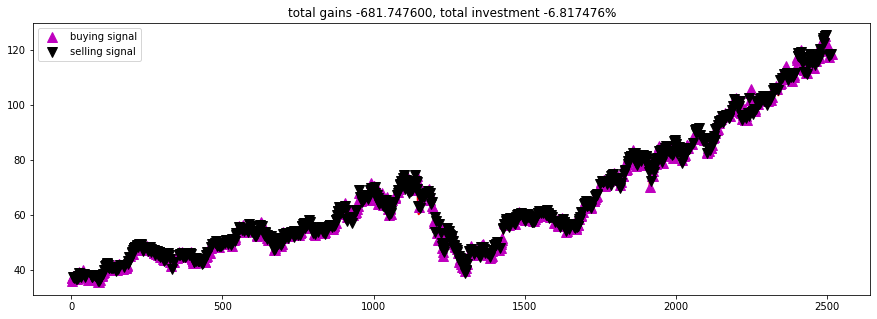

In [11]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = array['buy'])
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = array['sell'])
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.savefig('output/'+name+'.png')
plt.show()

In [ ]:
# Multiple execution 
NB_STOCKS = df_desc[df_desc['TYPE'] == 'Equity'].shape[0] 
invest = INVESTMENT // NB_STOCKS# slipt the amount invested
print(invest)
out  = [ agent.buy(initial_money = invest)
                    for isin in df_desc[df_desc['TYPE'] == 'Equity'].index ]